# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [271]:
import pandas as pd
import numpy as np
import math
import json
import itertools

import plotly.express as px
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

## Data loading

In [272]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data overview

### Portfolio data overview

 Display a basic overview of portfolio data.
 It shows:
* First 5 rows of the dataset
* An overview of columns (column name, number of non null values, and data type)    
* Statistics per columns (count, mean, standard deviation, and quartiles)
* A pie plot depicting the number of offers per type. 

In [273]:
# duration is depicted in hours instead of days
#portfolio.duration = portfolio.duration.apply(lambda x: x * 24)
# colors to plot
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

# display first 5 rows of the dataset
display(portfolio.head())

# display columns overview
print('Portfolio info:')
portfolio.info()
print('\n')

# display statistics per column
print('Portfolio stats:')
print(portfolio.describe())
print('\n')


# number of offers per type
offer_type_stats = portfolio.groupby('offer_type').size()

# map offer values to more informative labels
offer_type_stats_labels = offer_type_stats.index.map({'bogo':'Buy-One-Get-One',
                                              'discount':'Discount',
                                              'informational':'Informational',
                                              np.nan:'Not Available'})

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


Portfolio info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Portfolio stats:
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000




#### How is the offer portfolio composed?

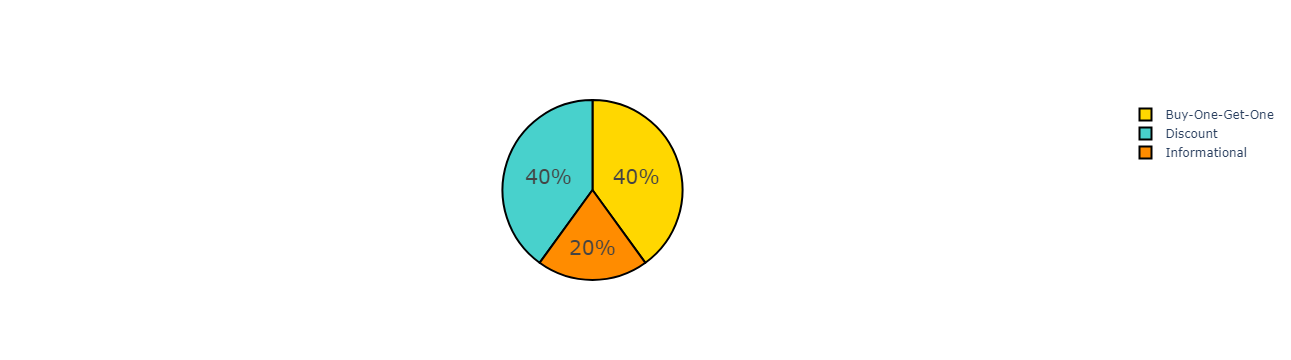

In [274]:
# plot offers per type
fig = go.Figure(data=[go.Pie(labels=offer_type_stats_labels, values=offer_type_stats.values)])
fig.update_traces(hoverinfo='label+value',
                  textinfo='percent',
                  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

### Profile data overview

 Display a basic overview of profile data.
 It shows:
* First 5 rows of the dataset
* An overview of columns (column name, number of non null values, and data type)    
* Statistics per columns (count, mean, standard deviation, and quartiles)
* A pie plot depicting profiles per gender
* A profile age histogram 
* A profile income histogram

In [275]:
# display first 5 rows of the dataset
display(profile.head())

# display columns overview
print('Profile info:')
profile.info()
print('\n')

# display statistics per column, except by `became_member_on`
print('Profile stats:')
print(profile.drop('became_member_on', axis=1).describe())
print('\n')

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Profile info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


Profile stats:
                age         income
count  17000.000000   14825.000000
mean      62.531412   65404.991568
std       26.738580   21598.299410
min       18.000000   30000.000000
25%       45.000000   49000.000000
50%       58.000000   64000.000000
75%       73.000000   80000.000000
max      118.000000  120000.000000




#### How many profiles per gender are depicted?

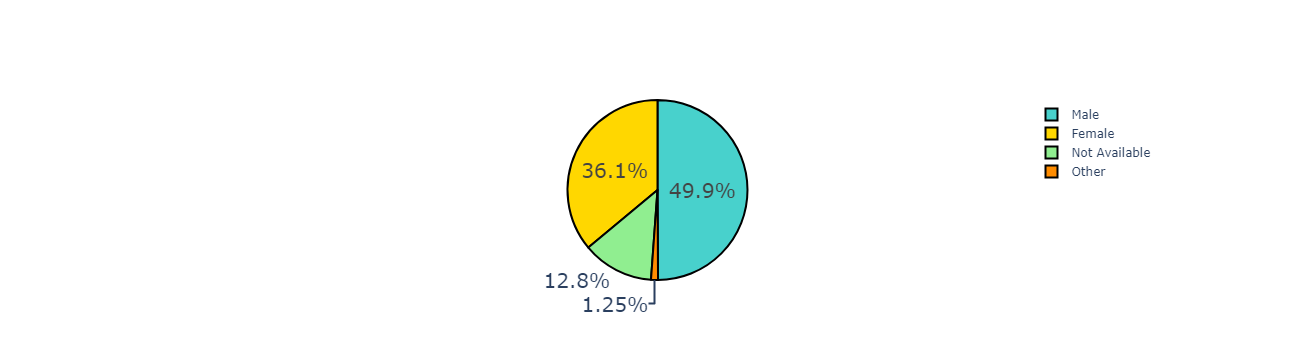

In [276]:
# number of profiles per gender
gender_stats = profile.groupby(['gender'], dropna=False).size()
# map gender values to more informative labels
gender_stats_labels = gender_stats.index.map({'F':'Female',
                                              'M':'Male',
                                              'O':'Other',
                                              np.nan:'Not Available'})

# plot profiles per gender
fig = go.Figure(data=[go.Pie(labels=gender_stats_labels, values=gender_stats.values)])
fig.update_traces(hoverinfo='label+value', 
                  textinfo='percent',
                  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

#### What's the distribution of profile ages?

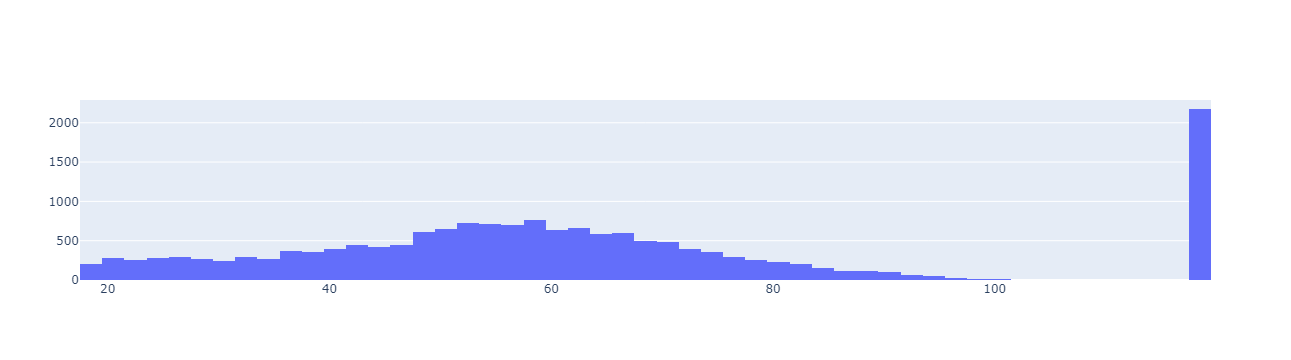

In [277]:
# plot age histogram
fig = go.Figure(data=[go.Histogram(x=profile.age.values)])
fig.show()

#### What's the distribution of profiles income?

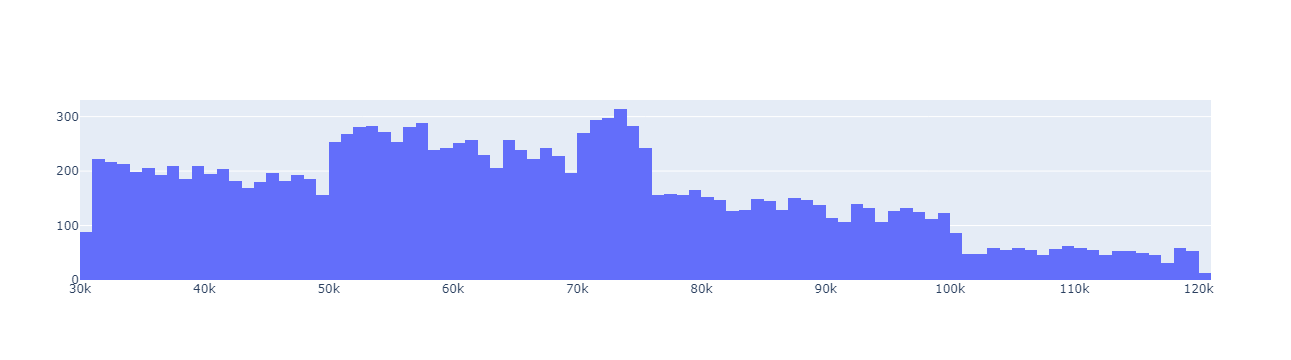

In [278]:
# plot income histogram
fig = go.Figure(data=[go.Histogram(x=profile.income.values)])
fig.show()

By reviewing the plots shown above, it turns out to be suspicious that the number of profiles without a specified `gender` and the number of 118-119 years-old profiles is very similar. Let's compare them y analyze some statistics.

#### What's the ratio of 118 years old profiles to overall profiles?

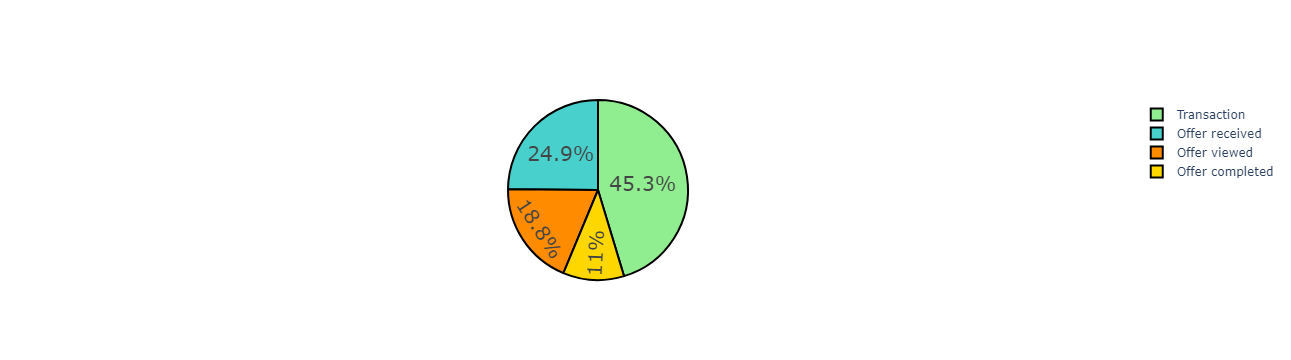

In [279]:
# plot transcripts per event type
fig = go.Figure(data=[go.Pie(labels=event_stats_labels, values=event_stats.values)])
fig.update_traces(hoverinfo='label+value', 
                  textinfo='percent',
                  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

#### Is the number of profiles without `gender` the same as the number of >110 years-old profiles?

In [280]:
# is the number of profiles without `gender` the same as the number of >110 years-old profiles?
assert(profile[profile.gender.isna()].shape[0] == profile[profile.age > 110].shape[0])

#### Stats on `age` and `income` fields

In [281]:
# stats on `age` and `income` fields
profile[profile.gender.isna()].drop('became_member_on', axis=1).describe()

,age,income
count,2175.0,0.0
mean,118.0,NaN
std,0.0,NaN
min,118.0,NaN
25%,118.0,NaN
50%,118.0,NaN
75%,118.0,NaN
max,118.0,NaN


#### How many 118 years old profiles compared to remaining ones exist?

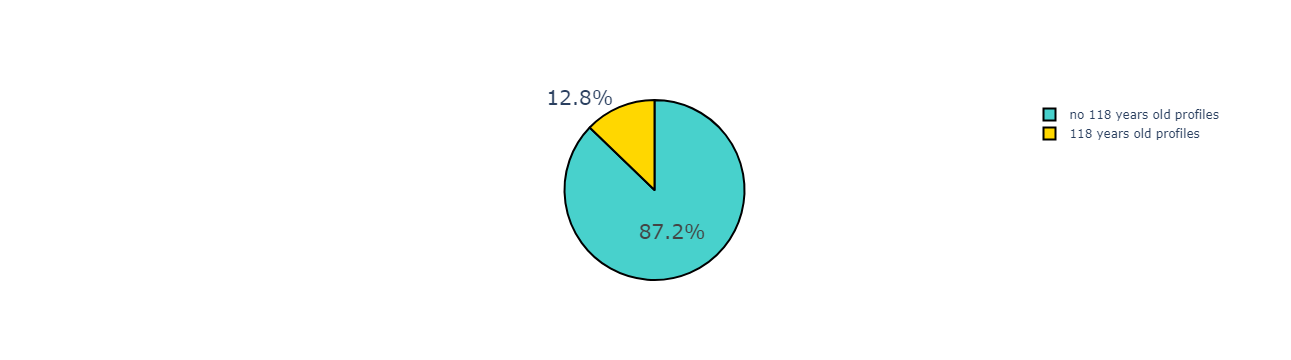

In [282]:
fig = go.Figure(data=[go.Pie(labels=['118 years old profiles',
                                     'no 118 years old profiles'],
                             values=[len(profile_id_list),
                                    profile.shape[0] - len(profile_id_list)])])
fig.update_traces(hoverinfo='label+value', 
                  textinfo='percent',
                  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

### Transcript data overview

In [283]:
# display first 5 rows of the dataset
display(transcript.head())

# display columns overview
print('Transcript info:')
transcript.info()
print('\n')

# number of events per type
event_stats = transcript.groupby(['event']).size()
# map event type values to better labels
event_stats_labels = event_stats.index.map({'transaction': 'Transaction',
                                            'offer received': 'Offer received',
                                            'offer viewed': 'Offer viewed',
                                            'offer completed': 'Offer completed'})

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Transcript info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB




### 118 years old profile data analysis
Some questions are interesting to be answer in order to get a better feeling on the dataset.
* How many transcripts the 118 years old profiles generate? 
* How many distinct 118 years old profiles generate those transcripts?
* What type of transcripts the 118 years old profiles generate?
* What's the percentage of offer received by the 118 years old profiles they actually viewed?
* What's the percentage of offer received by the 118 years old profiles they actually completed?

In [284]:
# list of 118 years old profile ids 
profile_id_list = profile[profile.age == 118]['id'].tolist()

# number of transcripts generated by 118 years old profiles
transcripts_num_by_118 = transcript[transcript.person.isin(profile_id_list)].shape[0]

# number of transcripts generated by remaining profiles
transcripts_num_by_others = transcript.shape[0] - transactions_num_by_118

# number of 118 years old profiles that generated at least 1 event
num_118_with_transcript = len(profile[profile.age == 118]['id'].isin(transcript.person))

# number of 118 years old profiles without event generated
num_118_without_transcript = len(profile[profile.age == 118]['id'].values) - num_118_with_transcript

# 118 years old profiles events generated per type
num_118_event_stats = transcript[transcript.person.isin(profile_id_list)].groupby('event').size()

#### How many transcripts are generated by 118 years old profiles compared to remaining ones?

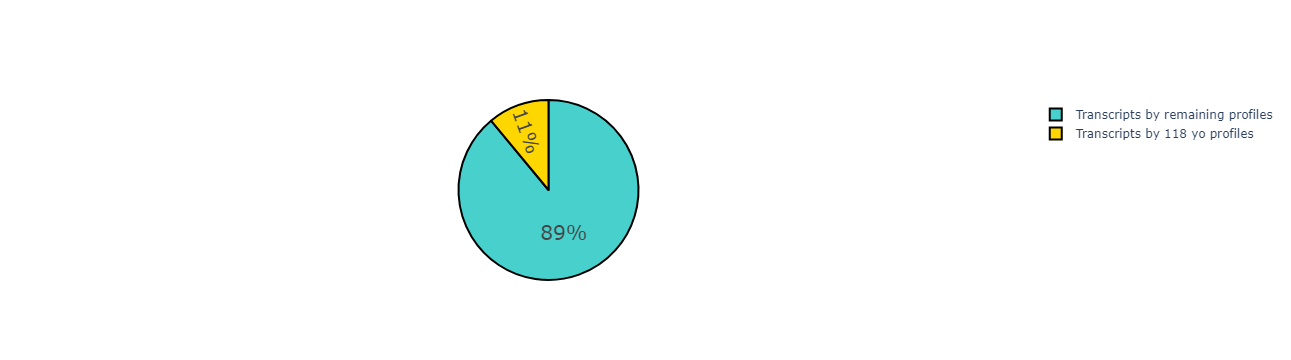

In [285]:
fig = go.Figure(data=[go.Pie(labels=['Transcripts by 118 yo profiles', 'Transcripts by remaining profiles'],
                             values=[transcripts_num_by_118, transcripts_num_by_others])])
fig.update_traces(hoverinfo='label+value', 
                  textinfo='percent',
                  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

#### How many 118 year old profiles generate at least one transaction?

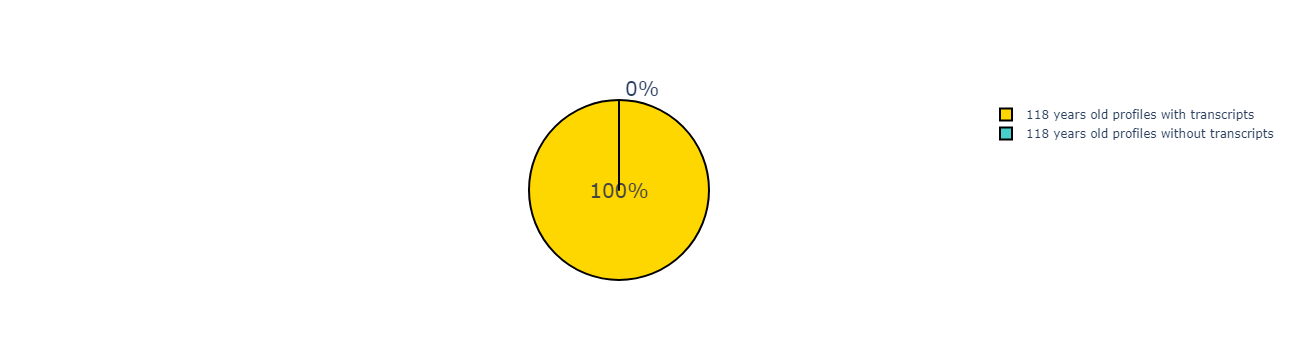

In [286]:
# plot 118 years old profiles with and without events
fig = go.Figure(data=[go.Pie(labels=['118 years old profiles with transcripts', '118 years old profiles without transcripts'],
                             values=[num_118_with_transcript, num_118_without_transcript])])
fig.update_traces(hoverinfo='label+value', 
                  textinfo='percent',
                  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

#### What's the event type composition of transcripts generated by 118 year old profiles?

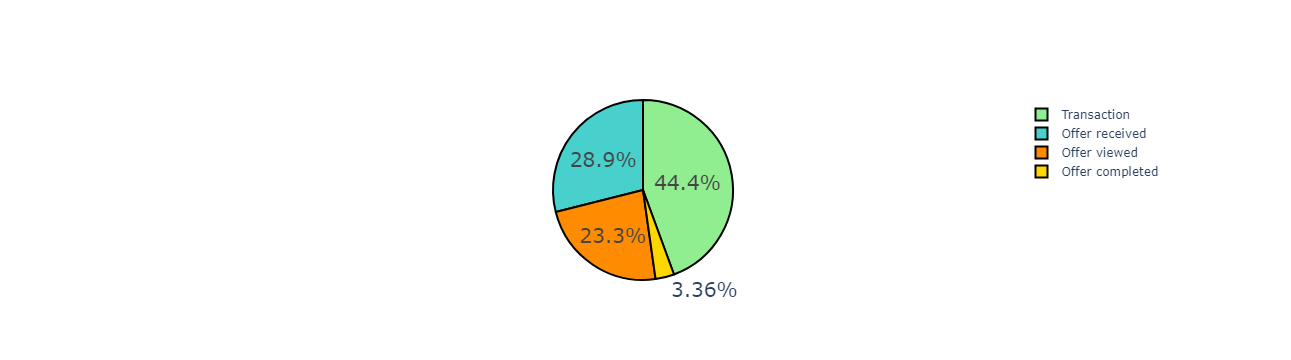

In [287]:
# plot transactions per event type
fig = go.Figure(data=[go.Pie(labels=event_stats_labels, values=num_118_event_stats.values)])
fig.update_traces(hoverinfo='label+value', 
                  textinfo='percent',
                  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

#### What's the ratio of offers viewed to offers reeived by 118 year old profiles?

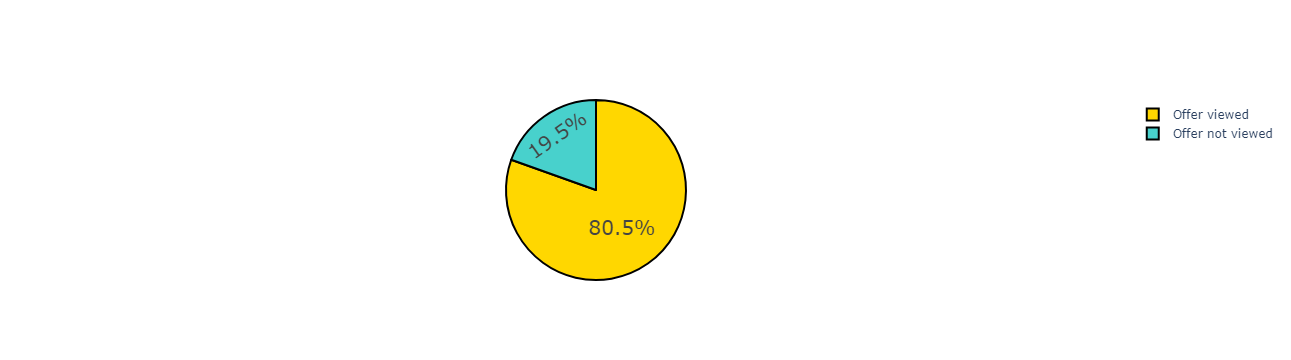

In [288]:
# plot offer received versus offer viewed
fig = go.Figure(data=[go.Pie(labels=['Offer viewed', 'Offer not viewed'],
                             values=[num_118_event_stats['offer viewed'], 
                                     num_118_event_stats['offer received'] - num_118_event_stats['offer viewed']])])
fig.update_traces(hoverinfo='label+value', 
                  textinfo='percent',
                  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

#### What's the ratio of offer completed to offer received by 118 year old profiles?

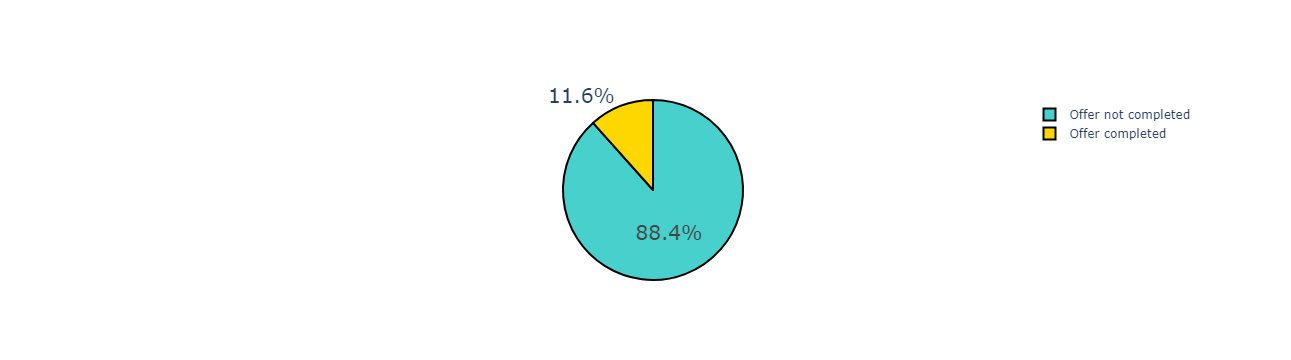

In [289]:
# plot offer viewed versus offer completed
fig = go.Figure(data=[go.Pie(labels=['Offer completed', 'Offer not completed'],
                             values=[num_118_event_stats['offer completed'],
                                     num_118_event_stats['offer received'] - num_118_event_stats['offer completed']])])
fig.update_traces(hoverinfo='label+value', 
                  textinfo='percent',
                  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()